# Imports

In [44]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re
import string

from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer

from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import Lasso
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, KFold, cross_validate, cross_val_score, train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report, plot_confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTE


import tensorflow
import keras
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D, Embedding, Activation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import ModelCheckpoint

import random
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras import optimizers

# Dataframe Initialization and Observations

In [45]:
# load data and initialize dataframe
df = pd.read_csv('./data/judge-1377884607_tweet_product_company.csv',
                 encoding="ISO-8859-1")
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [46]:
# check for nulls and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [47]:
# count nulls
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [48]:
# split tweet_text to create unprocessed_text - we'll make a visualization with this and compare it with preprocessed_text
df['unprocessed_text'] = df['tweet_text'].str.split()

In [49]:
# drop the last rough because those characters or tweet_text cannot be useful after preprocessing
df.drop(index=df.index[-1],
        axis=0,
        inplace=True)

df.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,unprocessed_text
9087,"@mention Yup, but I don't have a third app yet...",NaN,No emotion toward brand or product,"[@mention, Yup,, but, I, don't, have, a, third..."
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion,"[Ipad, everywhere., #SXSW, {link}]"
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product,"[Wave,, buzz..., RT, @mention, We, interrupt, ..."
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product,"[Google's, Zeiger,, a, physician, never, repor..."
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,"[Some, Verizon, iPhone, customers, complained,..."


### Summary

We have a large number of nulls in the data set. We will need to figure out how to handle these nulls in data cleaning in addition to the standard NLP data cleaning procedures such as RegEx, stopword removal, lemmatization,  and tokenization. 

# Data Cleanup

In [50]:
# function to preprocess tweets
def clean_hash_mentions(tweet):
    # pattern to remove hashtags and mentions
    hashtag_mention_pattern = '([@#][\w_-]+)'
    
    # remove hashtags and mentions
    tweet_clean = re.sub(hashtag_mention_pattern, '', str(tweet))
    
    # lower case
    tweet_clean = tweet_clean.lower()
    
    # tokenize tweet
    pattern = "([a-zA-Z0-9]+(?:'[a-z]+)?)"
    tweet_clean = RegexpTokenizer(tweet_clean, pattern)
    
    # join tweet back together
    tweet_clean = ' '.join(str(tweet_clean))

    return str(tweet_clean)

In [51]:
def process_string(text):
    """This function returns a processed list of words from the given text
    
    This function removes html elements and urls using regular expression, then
    converts string to list of workds, them find the stem of words in the list of words and
    finally removes stopwords and punctuation marks from list of words.
    
    Args:
        text(string): The text from which html elements, urls, stopwords, punctuation are removed and lemmatized
        
    Returns:
        clean_text(string): A text formed after text preprocessing.
    """
    # Remove twitter user handle from the text
    text = re.sub('@[^\s]+',
                  '',
                  str(text))
    
    # Remove any urls from the text
    text = re.sub(r'https:\/\/.*[\r\n]*',
                  "",
                  str(text))
    
    # Remove any urls starting from www. in the text
    text = re.sub(r'www\.\w*\.\w\w\w',
                  "",
                  str(text))
    
    # Remove any html elements from the text
    text = re.sub(r"<[\w]*[\s]*/>",
                  "",
                  str(text))
    
    # Remove prediods  marks
    text = re.sub(r"[\.]*",
                  "",
                  str(text))
    
    # Initialize RegexpTokenizer
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokenizer = RegexpTokenizer(pattern)

    # Tokenize text
    text_tokens = tokenizer.tokenize(text.lower())
    
    # Instantiate lemmatizer
    lemmatizer  = WordNetLemmatizer()
    
    # Get english stopwords
    english_stopwords = stopwords.words("english")
    new_list = ['mention', 'sxsw', 'sxswi', 'link', 'rt', 'quot', 'g']
    english_stopwords.extend(new_list)
    
    cleaned_text_tokens = [] # A list to hold cleaned text tokens
    
    for word in text_tokens:
        if((word not in english_stopwords) and # Remove stopwords
            (word not in string.punctuation)): # Remove punctuation marks
                
                lemmas = lemmatizer.lemmatize(word) # Get lemma of the current word
                cleaned_text_tokens.append(lemmas) # Appened lemma word to list of cleaned list
    
    # Combine list into single string
    clean_text = " ".join(cleaned_text_tokens)
    
    return clean_text

In [52]:
# create new column clean_tweet
df['clean_tweet'] = df['tweet_text'].map(clean_hash_mentions)

In [53]:
# apply cleanup function to tweet_text column
df['tweet_text'] = df['tweet_text'].apply(process_string)

In [54]:
# now that it's clean, split tweet_text again to create preprocessed_text
# we'll make a visualization with this and compare it with preprocessed_text
df['preprocessed_text'] = df['tweet_text'].str.split()

In [55]:
# view nulls vs subcategories in emotion_in_tweet_is_directed_at column
df['emotion_in_tweet_is_directed_at'].value_counts(dropna=False)

NaN                                5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [56]:
# defining dictionary map and mapping
manufacturer_map = {
    'iPad': 'Apple',
    'Apple': 'Apple',
    'iPad or iPhone App': 'Apple',
    'iPhone': 'Apple',
    'Other Apple product or service': 'Apple',
    
    'Google': 'Google',
    'Other Google product or service': 'Google',
    'Android App': 'Google',
    'Android': 'Google'}

df['Manufacturer'] = df['emotion_in_tweet_is_directed_at'].map(manufacturer_map)
df['Manufacturer'].value_counts(dropna=False, normalize=True)

NaN       0.638033
Apple     0.264958
Google    0.097008
Name: Manufacturer, dtype: float64

In [57]:
df['Manufacturer'].fillna(value='Unknown', inplace=True)
df['Manufacturer'].value_counts(normalize=True)

Unknown    0.638033
Apple      0.264958
Google     0.097008
Name: Manufacturer, dtype: float64

In [58]:
# check if those 757 nulls are the only ones missing
df.isnull().sum()

tweet_text                                               0
emotion_in_tweet_is_directed_at                       5801
is_there_an_emotion_directed_at_a_brand_or_product       0
unprocessed_text                                         1
clean_tweet                                              0
preprocessed_text                                        0
Manufacturer                                             0
dtype: int64

In [59]:
df[df['unprocessed_text'].isnull()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,unprocessed_text,clean_tweet,preprocessed_text,Manufacturer
6,nan,NaN,No emotion toward brand or product,NaN,R e g e x p T o k e n i z e r ( p a t t e r n ...,[nan],Unknown


In [60]:
# drop the last rough because those characters or tweet_text cannot be useful after preprocessing
df.drop(index=df.index[6],
        axis=0,
        inplace=True)

In [61]:
# fill null with 'Unknown' for directed_at
df.emotion_in_tweet_is_directed_at.fillna(value='Unknown', inplace=True)

In [62]:
df.isnull().sum()

tweet_text                                            0
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
unprocessed_text                                      0
clean_tweet                                           0
preprocessed_text                                     0
Manufacturer                                          0
dtype: int64

In [63]:
# rename columns
df.rename(columns={'tweet_text':'Text', 'is_there_an_emotion_directed_at_a_brand_or_product' : 'Sentiment', 'emotion_in_tweet_is_directed_at' : 'directed_at'}, inplace=True)

In [64]:
df = df.reset_index()

# create a new data frame with "id" and "comment" fields
df_subset = df[['index', 'Sentiment']].copy()

# data clean-up
# remove all non-aphabet characters
df_subset['Sentiment'] = df_subset['Sentiment'].str.replace("[^a-zA-Z#]", " ")

# covert to lower-case
df_subset['Sentiment'] = df_subset['Sentiment'].str.casefold()
# print (df_subset.head(10))

# set up empty dataframe for staging output
df1 = pd.DataFrame()
df1['index'] = ['99999999999']
df1['sentiment_type']='NA999NA'
df1['sentiment_score']=0

print('Processing sentiment analysis...')
sid = SentimentIntensityAnalyzer()
t_df = df1

for index, row in df_subset.iterrows():
    scores = sid.polarity_scores(row[1])

    for key, value in scores.items():
        temp = [key, value, row[0]]
        df1['index'] = row[0]
        df1['sentiment_type'] = key
        df1['sentiment_score'] = value
        t_df = t_df.append(df1)

# remove dummy row with row_id = 99999999999
t_df_cleaned = t_df[t_df.index != '99999999999']

# remove duplicates if any exist
t_df_cleaned = t_df_cleaned.drop_duplicates()

# only keep rows where sentiment_type = compound
t_df_cleaned = t_df[t_df.sentiment_type == 'compound']

# print(t_df_cleaned.head(10))

# merge dataframes
df = pd.merge(df, t_df_cleaned, on='index', how='inner')

df.head()

Processing sentiment analysis...


,index,Text,directed_at,Sentiment,unprocessed_text,clean_tweet,preprocessed_text,Manufacturer,sentiment_type,sentiment_score
0,0,iphone hr tweeting rise austin dead need upgra...,iPhone,Negative emotion,"[.@wesley83, I, have, a, 3G, iPhone., After, 3...",R e g e x p T o k e n i z e r ( p a t t e r n ...,"[iphone, hr, tweeting, rise, austin, dead, nee...",Apple,compound,-0.5719
1,1,know awesome ipad iphone app likely appreciate...,iPad or iPhone App,Positive emotion,"[@jessedee, Know, about, @fludapp, ?, Awesome,...",R e g e x p T o k e n i z e r ( p a t t e r n ...,"[know, awesome, ipad, iphone, app, likely, app...",Apple,compound,0.5574
2,2,wait ipad also sale,iPad,Positive emotion,"[@swonderlin, Can, not, wait, for, #iPad, 2, a...",R e g e x p T o k e n i z e r ( p a t t e r n ...,"[wait, ipad, also, sale]",Apple,compound,0.5574
3,3,hope year's festival crashy year's iphone app,iPad or iPhone App,Negative emotion,"[@sxsw, I, hope, this, year's, festival, isn't...",R e g e x p T o k e n i z e r ( p a t t e r n ...,"[hope, year's, festival, crashy, year's, iphon...",Apple,compound,-0.5719
4,4,great stuff fri marissa mayer google tim o'rei...,Google,Positive emotion,"[@sxtxstate, great, stuff, on, Fri, #SXSW:, Ma...",R e g e x p T o k e n i z e r ( p a t t e r n ...,"[great, stuff, fri, marissa, mayer, google, ti...",Google,compound,0.5574


In [65]:
df.drop(columns='sentiment_type', inplace=True)

In [66]:
# check value counts for Sentiment column
df['Sentiment'].value_counts(dropna=False)

No emotion toward brand or product    5387
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: Sentiment, dtype: int64

In [67]:
# check to see if the Sentiment columns "I can't tell values" have a sentiment_score 
# if they do then we can properly classify them as negative, positive, or neural
df[df['Sentiment'] == "I can't tell"]

,index,Text,directed_at,Sentiment,unprocessed_text,clean_tweet,preprocessed_text,Manufacturer,sentiment_score
89,90,thanks publishing news new medical apps conf b...,Unknown,I can't tell,"[Thanks, to, @mention, for, publishing, the, n...",R e g e x p T o k e n i z e r ( p a t t e r n ...,"[thanks, publishing, news, new, medical, apps,...",Unknown,0.0
101,102,apple opened pop store austin nerd town get ne...,Unknown,I can't tell,"[ÛÏ@mention, &quot;Apple, has, opened, a, pop...",R e g e x p T o k e n i z e r ( p a t t e r n ...,"[apple, opened, pop, store, austin, nerd, town...",Unknown,0.0
236,237,america need google launch major new social ne...,Unknown,I can't tell,"[Just, what, America, needs., RT, @mention, Go...",R e g e x p T o k e n i z e r ( p a t t e r n ...,"[america, need, google, launch, major, new, so...",Unknown,0.0
340,341,queue apple store austin four block long crazy...,Unknown,I can't tell,"[The, queue, at, the, Apple, Store, in, Austin...",R e g e x p T o k e n i z e r ( p a t t e r n ...,"[queue, apple, store, austin, four, block, lon...",Unknown,0.0
367,368,hope better wave buzz google's previewing soci...,Unknown,I can't tell,"[Hope, it's, better, than, wave, RT, @mention,...",R e g e x p T o k e n i z e r ( p a t t e r n ...,"[hope, better, wave, buzz, google's, previewin...",Unknown,0.0
...,...,...,...,...,...,...,...,...,...
9019,9020,funny watching room full people hold ipad air ...,Unknown,I can't tell,"[It's, funny, watching, a, room, full, of, peo...",R e g e x p T o k e n i z e r ( p a t t e r n ...,"[funny, watching, room, full, people, hold, ip...",Unknown,0.0
9031,9032,yeah google nothing u,Unknown,I can't tell,"[@mention, yeah,, we, have, @mention, ,, Googl...",R e g e x p T o k e n i z e r ( p a t t e r n ...,"[yeah, google, nothing, u]",Unknown,0.0
9036,9037,yes google presentation exactly expecting,Unknown,I can't tell,"[@mention, Yes,, the, Google, presentation, wa...",R e g e x p T o k e n i z e r ( p a t t e r n ...,"[yes, google, presentation, exactly, expecting]",Unknown,0.0
9057,9058,know apple really good making feel bad xmas pr...,Unknown,I can't tell,"[&quot;Do, you, know, what, Apple, is, really,...",R e g e x p T o k e n i z e r ( p a t t e r n ...,"[know, apple, really, good, making, feel, bad,...",Unknown,0.0


In [68]:
# drop 'I can't tell' as this will not be relevant for modeling
# we can't match with the correct Sentiment value because they have 0 as their scores
df = df[df['Sentiment'] != "I can't tell"]

In [69]:
# defining dictionary map and mapping
sentiment_map = {
    'Positive emotion': 'Positive',
    'Negative emotion': 'Negative',
    'No emotion toward brand or product': 'Neutral'}

In [70]:
df['Sentiment'] = df['Sentiment'].map(sentiment_map)

In [71]:
# final check
df['Sentiment'].value_counts(normalize=True)

Neutral     0.602910
Positive    0.333296
Negative    0.063794
Name: Sentiment, dtype: float64

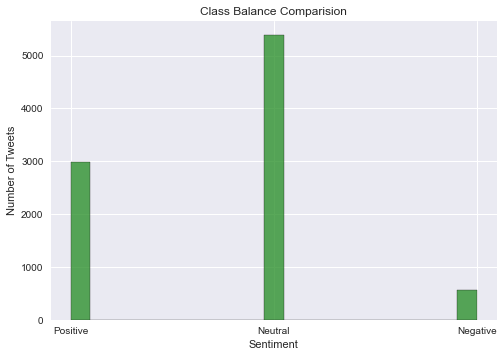

In [72]:
# Plot the class the balance on a histogram
class_balance = sns.histplot(data=df['Sentiment'].sort_values(ascending=False),
                             color='#228B22',
                             discrete=False)

class_balance.set_title("Class Balance Comparision")
class_balance.set_xlabel("Sentiment")
class_balance.set_ylabel("Number of Tweets");

# Wordclouds and Graphs

In [73]:
# defining dictionary map and mapping
company_map = {
    'iPad': 'Apple',
    'Apple': 'Apple',
    'iPad or iPhone App': 'Apple',
    'iPhone': 'Apple',
    'Other Apple product or service': 'Apple',
    
    'Google': 'Google',
    'Other Google product or service': 'Google',
    'Android App': 'Google',
    'Android': 'Google'}

df['company'] = df['directed_at'].map(company_map)
df['company'].value_counts(dropna=False, normalize=True)

NaN       0.632680
Apple     0.268830
Google    0.098489
Name: company, dtype: float64

In [74]:
# categorize Tweets by 'Manufacturer' based on if Tweet contains certain keywords words
# instantiate list of keywords
is_apple = ['ipad', 
            "ipad's", 
            'iphone', 
            'iphones', 
            "iphone's",
            'ipod',
            'itunes',
            'apple', 
            "apple's", 
            'mac', 
            'macos' 
            'ios', 
            'os' 
            'macbook', 
            'macbook pro', 
            'm1', 
            'macbook air',
            'air',
            'airpod', 
            'airpods',
            'airtag',
            'watch',
            'panther',
            'tiger',
            'leopard',
            'lion',
            'mavericks',
            'monterey',
            'big sur',
            'catalina',
            'mojave',
            'high sierra',
            'sierra',
            'el capitan',
            'yosemite',
            'icloud']

is_google = ['windows', 
             'google', 
             "google's", 
             'googles',
             'googled',
             'pixel', 
             "pixel's", 
             'pixels', 
             'android', 
             "android's", 
             "androids", 
             'nest']

In [75]:
# define functions that loop through keyword lists and assign a category in a new column in the df
def apple_sorter(x):
    for i in is_apple:
        if i.lower() in x.lower():
            return 'Apple'
        else:
            continue
        
def google_sorter(x):
    for i in is_google:
        if i.lower() in x.lower():
            return 'Google'
        else:
            continue

In [76]:
# apply apple and google sorters to tweet_text
df['company'] = df['Text'].apply(apple_sorter)
df['Google'] = df['Text'].apply(google_sorter)

In [77]:
# merge created columns into 1 master column, 'Manufacturer'
df['company'] = df['company'].combine_first(df['Google'])

In [78]:
# drop extraneous columns
df.drop('Google', axis=1, inplace=True)
# df.drop('emotion_in_tweet_is_directed_at', axis=1, inplace=True)

In [79]:
df['company'].fillna(value='Unknown', inplace=True)
df['company'].value_counts(normalize=True)

Apple      0.628763
Google     0.294460
Unknown    0.076777
Name: company, dtype: float64

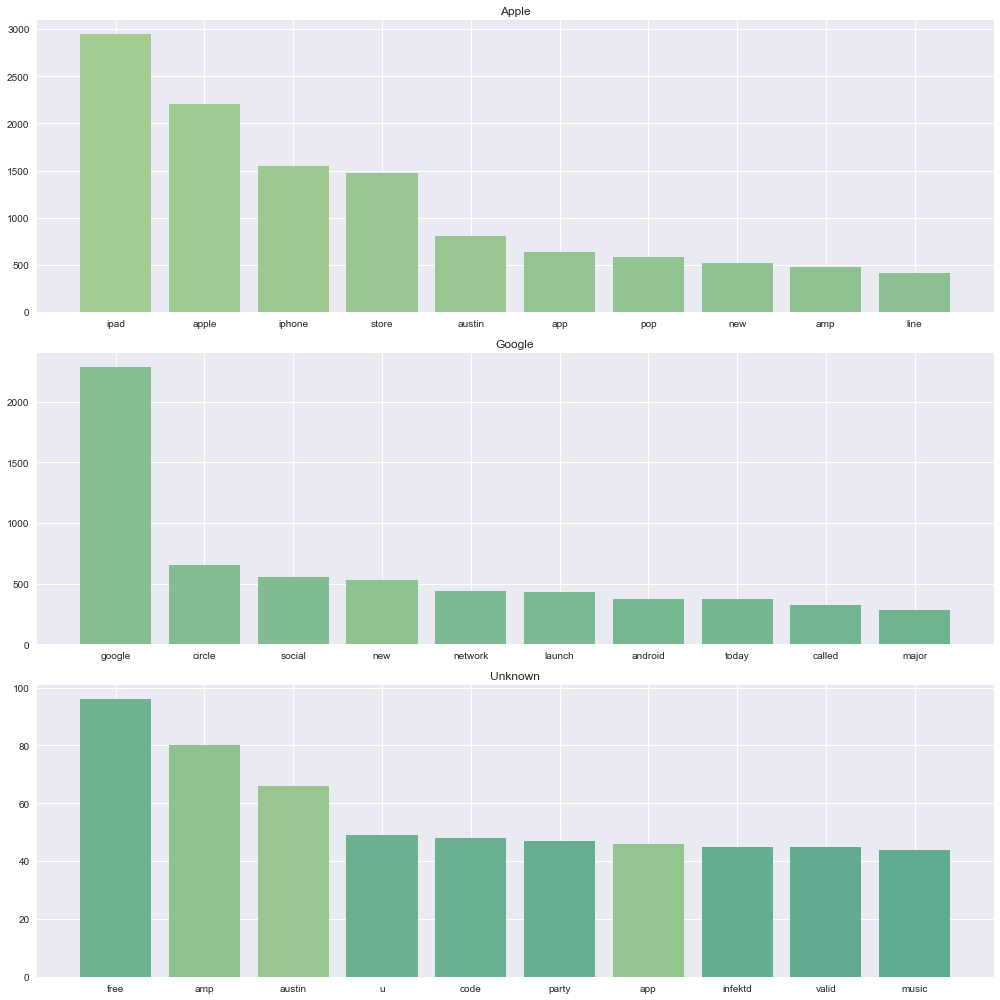

In [80]:
# Set up figure and axes
fig, axes = plt.subplots(nrows=3, figsize=(14, 14))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}

# Establish color palette to pull from
# (If you get an error message about popping from an empty list, increase this #)
color_palette = sns.color_palette('crest', n_colors=100)

# Creating a plot for each unique genre
data_by_company = [y for _, y in df.groupby('company', as_index=False)]
for index, company_df in enumerate(data_by_company):
    
    # Find top 10 words in this genre
    all_words_in_company = company_df.preprocessed_text.explode()
    top_10 = all_words_in_company.value_counts()[:10]
    
    # Select appropriate colors, reusing colors if words repeat
    colors = []
    for word in top_10.index:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[index]
    ax.bar(top_10.index, top_10.values, color=colors)
    ax.set_title(company_df.iloc[0].company.title())
    
fig.tight_layout()

plt.savefig('images/apple_google_top_words.png');

In [81]:
twitter_mask = np.array(Image.open("./images/twitter_mask.png"))
twitter_mask

array([[[  2,   2,   2, 110],
        [180, 180, 180, 238],
        [253, 253, 253, 255],
        ...,
        [250, 250, 250, 255],
        [158, 158, 158, 233],
        [  2,   2,   2, 110]],

       [[180, 180, 180, 238],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [158, 158, 158, 233]],

       [[253, 253, 253, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [250, 250, 250, 255]],

       ...,

       [[250, 250, 250, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [250, 250, 250, 255]],

       [[158, 158, 158, 233],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [158, 158, 158, 233]],

       [[  2

In [82]:
# creating a word cloud image with a twitter mask
# stop words
stopwords_list = stopwords.words('english')

# add to stop words
stopwords_list += ['sxsw', 'swswi', 'link', 'rt', 'quot', 'g']

In [83]:
# creating a corpus for positive tweets only 
apple = df[df['company'] == "Apple"]
apple_corpus = apple['Text'].to_list()
apple_corpus = ",".join(apple_corpus)

In [84]:
# word tokenize and lowercase all words 
apple_tokens = word_tokenize(apple_corpus)
apple_stopped = [token.lower() for token in apple_tokens if token.lower() not in stopwords_list]

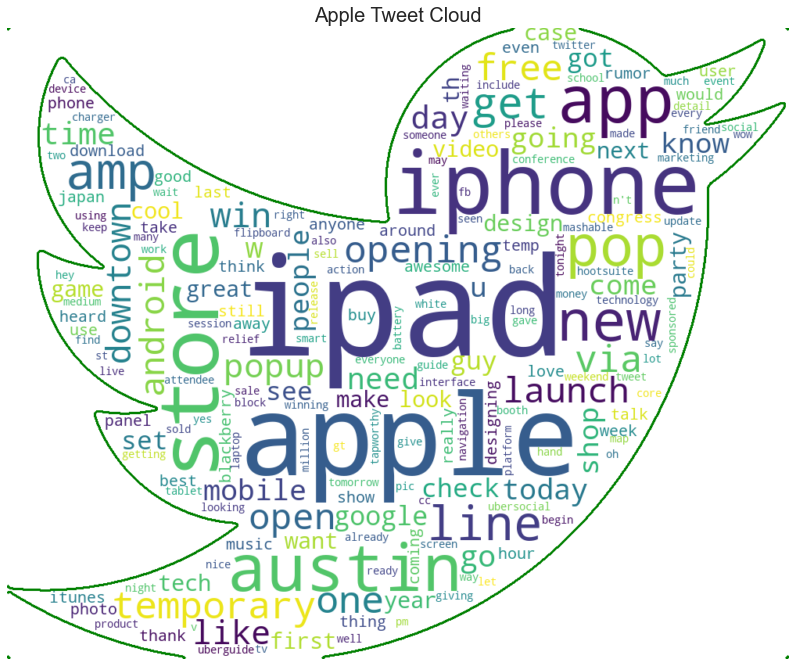

In [85]:
# generating a wordcloud with a twitter mask for positive words only 
wordcloud = WordCloud(stopwords=stopwords_list,
                      collocations=False, 
                      mask=twitter_mask, 
                      background_color='white', 
                      width=1800,
                      height=1400, 
                      contour_color='green', 
                      contour_width=2)

wordcloud.generate(','.join(apple_stopped))

plt.figure(figsize=(14, 14), 
           facecolor=None)

plt.imshow(wordcloud, 
           interpolation='bilinear')

plt.title('Apple Tweet Cloud', 
          size=20)

plt.axis("off")

plt.savefig('images/apple_tweet_cloud');

In [93]:
# creating a corpus for positive tweets only 
google = df[df['company'] == "Google"]
google_corpus = google['Text'].to_list()
google_corpus = ",".join(google_corpus)

In [94]:
# word tokenize and lowercase all words 
google_tokens = word_tokenize(google_corpus)
google_stopped = [token.lower() for token in google_tokens if token.lower() not in stopwords_list]

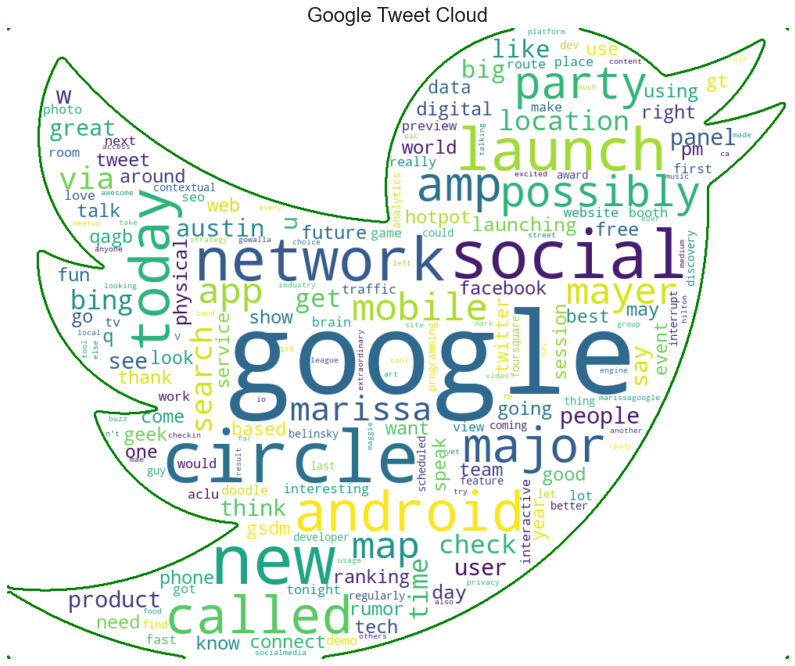

In [95]:
# generating a wordcloud with a twitter mask for positive words only 
wordcloud = WordCloud(stopwords=stopwords_list,
                      collocations=False, 
                      mask=twitter_mask, 
                      background_color='white', 
                      width=1800,
                      height=1400, 
                      contour_color='green', 
                      contour_width=2)

wordcloud.generate(','.join(google_stopped))

plt.figure(figsize=(14, 14), 
           facecolor=None)

plt.imshow(wordcloud, 
           interpolation='bilinear')

plt.title('Google Tweet Cloud', 
          size=20)

plt.axis("off")

plt.savefig('images/google_tweet_cloud');

# Train/Test Split, Label Encoding, Vectorization

In [96]:
# function to turn series to dataframe
def series_to_dataframe(series):
    return pd.DataFrame(series)

# Function Transformer
series_FT = FunctionTransformer(series_to_dataframe)

In [97]:
def lemmatize(tweet):
    # split tweet
    tweet_split = tweet.split()
    
    # tokenize and lemmatize
    lem = WordNetLemmatizer()
    tweet_token = [lem.lemmatize(word) for word in tweet_split]
    return tweet_token

In [98]:
# # adding additional words to stopwords_list
# new_stopwords_list = stopwords_list
# new_stopwords_list += ['ipad', 'apple', 'google', 'store', 'iphone', 'quot']

In [99]:
# Set X and y
X = df[['clean_tweet', 'Manufacturer']]

# mapping target to -1, 0, 1
y = df['Sentiment'].map({'Negative': -1, 'Neutral': 0, 'Positive': 1})

# train test split with test size = 10% and random_state for result interpretability
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=.10,
                                                    random_state=42, 
                                                    stratify=y)

In [ ]:
# # tfidf vectorizer
# tfidf = TfidfVectorizer(stop_words=stopwords_list, max_features=500, ngram_range=(1,3), min_df=5, tokenizer=lemmatize)

# # list of models
# models = [
#     LogisticRegression(),
#     DecisionTreeClassifier(max_depth=5),
#     RandomForestClassifier(max_depth=5),
#     MultinomialNB(),    
#     GradientBoostingClassifier(n_estimators=100)
# #     AdaBoostClassifier(),
# #     xgboost.XGBClassifier(reg_lambda=5.0)
# ]

# # for loop to run through each model and print cross-val
# for model in models:
#     # steps for pipeline
#     steps = [
#     ('tfidf', tfidf),
#     ('model', model)
#     ]
    
#     #pipeline
#     pipe = Pipeline(steps)
#     pipe.fit(X_train['clean_tweet'], y_train)
#     print(model)
#     print_cross_validate(pipe, X_train['clean_tweet'], y_train)
#     print('')

# Machine Learning Models

#### Helper Function

#### Baseline Model (Dummy)

              precision    recall  f1-score   support

     Neg (-)       0.00      0.00      0.00        57
     Neutral       0.60      1.00      0.75       539
     Pos (+)       0.00      0.00      0.00       298

    accuracy                           0.60       894
   macro avg       0.20      0.33      0.25       894
weighted avg       0.36      0.60      0.45       894



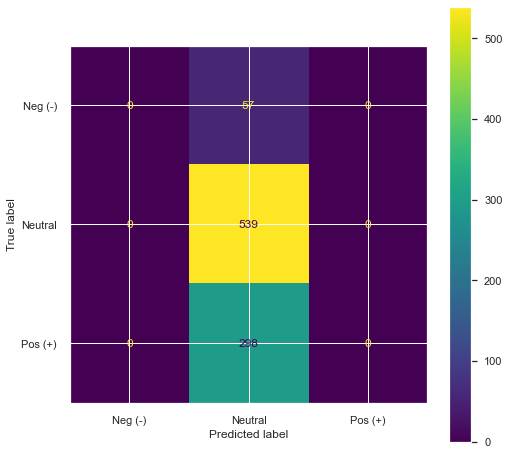

In [100]:
# Create Dummy/Baseliner
estimator = DummyClassifier(strategy='most_frequent')
estimator.fit(X_train, y_train)

# Get predictions with dummy model
y_pred = estimator.predict(X_test)

# Set figsize and font scale
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Neg (-)', 'Neutral', 'Pos (+)']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=estimator,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_Dummy');

target_names = ['Neg (-)', 'Neutral', 'Pos (+)']
print(classification_report(y_test, y_pred, target_names=target_names))

Dummy model predicts 'Neutral' for all and has an accuracy of 60%

#### Logistic Regression with SMOTE

Fitting 30 folds for each of 15 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 21.7min finished


Mean Training Score: 85.51%

Mean Test Score: 84.90%

Optimal Parameters: {'estimator__C': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}

Testing Accuracy: 84.96%

              precision    recall  f1-score   support

          -1       0.32      0.61      0.42        57
           0       0.93      0.97      0.95       539
           1       0.90      0.67      0.77       298

    accuracy                           0.85       894
   macro avg       0.72      0.75      0.71       894
weighted avg       0.88      0.85      0.86       894



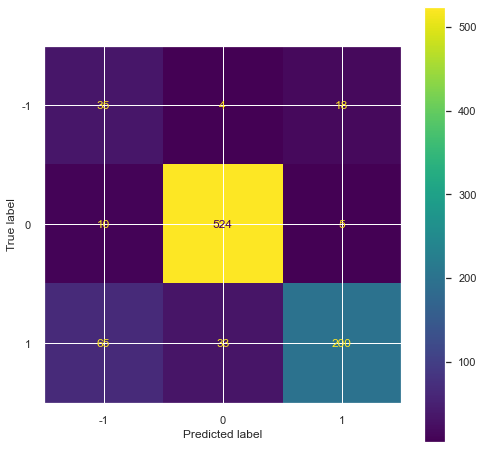

In [52]:
# tfidf vectorizer
tfidf = TfidfVectorizer(stop_words=stopwords_list, max_features=500, ngram_range=(1,3), min_df=2, tokenizer=lemmatize)

# One hot encoder
ohe = OneHotEncoder(handle_unknown='ignore')

# pipeline to one hot encode dataframe
ohe_pipe = Pipeline(steps=[
    ('to_df', series_FT),
    ('ohe', ohe),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

# pipeline for vectorizing
vector_pipe = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ('vector', tfidf),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

# pipeline for TfIdf and One Hot Encoder
CT = ColumnTransformer(transformers=[
    ('vector_pipe', vector_pipe, ['clean_tweet']),
    ('ohe_pipe', ohe_pipe, ['Manufacturer'])
], remainder='passthrough')

# logreg pipeline
pipe = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTE(random_state=42)),
    ('estimator', LogisticRegression())
])

param_grid = {}
param_grid['estimator__C'] = [100, 10, 1.0, 0.1, 0.01]
param_grid['estimator__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
param_grid['estimator__penalty'] = ['l2']

grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           verbose=1)

# Fit models run gridsearch
grid_search.fit(X_train, y_train)

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

# Set figsize and font scale
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Neg (-)', 'Neutral', 'Pos (+)']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=best_grid,
                      X=X_test,
                      y_true=y_test)

target_names = ['Neg (-)', 'Neutral', 'Pos (+)']
print(classification_report(y_test, y_pred))

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_LogReg_SMOTE');

#### Logistic without SMOTE

Fitting 30 folds for each of 15 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 16.5min finished


Mean Training Score: 89.68%

Mean Test Score: 88.70%

Optimal Parameters: {'estimator__C': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}

Testing Accuracy: 89.30%

              precision    recall  f1-score   support

          -1       0.43      0.05      0.09        57
           0       0.93      0.98      0.96       539
           1       0.82      0.88      0.85       298

    accuracy                           0.89       894
   macro avg       0.73      0.64      0.63       894
weighted avg       0.86      0.89      0.86       894



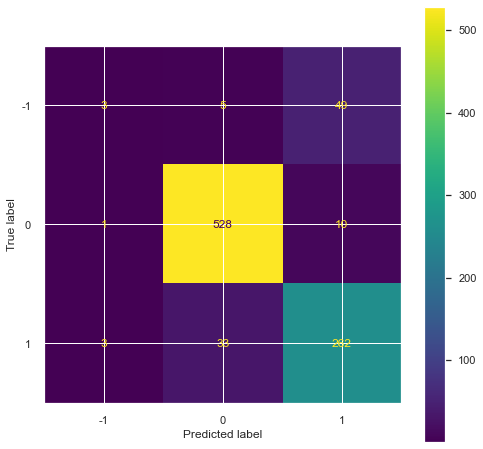

In [101]:
# tfidf vectorizer
tfidf = TfidfVectorizer(stop_words=stopwords_list, max_features=500, ngram_range=(1,3), min_df=2, tokenizer=lemmatize)

# One hot encoder
ohe = OneHotEncoder(handle_unknown='ignore')

# pipeline to one hot encode dataframe
ohe_pipe = Pipeline(steps=[
    ('to_df', series_FT),
    ('ohe', ohe),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

# pipeline for vectorizing
vector_pipe = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ('vector', tfidf),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

# pipeline for TfIdf and One Hot Encoder
CT = ColumnTransformer(transformers=[
    ('vector_pipe', vector_pipe, ['clean_tweet']),
    ('ohe_pipe', ohe_pipe, ['Manufacturer'])
], remainder='passthrough')

# logreg pipeline
pipe = Pipeline(steps=[
    ('ct', CT),
    ('estimator', LogisticRegression())
])

param_grid = {}
param_grid['estimator__C'] = [100, 10, 1.0, 0.1, 0.01]
param_grid['estimator__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
param_grid['estimator__penalty'] = ['l2']

grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           verbose=1)

# Fit models run gridsearch
grid_search.fit(X_train, y_train)

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

# Set figsize and font scale
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Neg (-)', 'Neutral', 'Pos (+)']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=best_grid,
                      X=X_test,
                      y_true=y_test)

target_names = ['Neg (-)', 'Neutral', 'Pos (+)']
print(classification_report(y_test, y_pred))

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_LogReg');

Performs better on unseen data without SMOTE, we will not use SMOTE in our next models

#### Ridge Regression

Fitting 30 folds for each of 10 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.8min finished


Mean Training Score: 89.23%

Mean Test Score: 88.70%

Optimal Parameters: {'estimator__alpha': 0.1}

Testing Accuracy: 89.24%

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        57
           0       0.93      0.98      0.96       539
           1       0.81      0.89      0.85       298

    accuracy                           0.89       894
   macro avg       0.58      0.62      0.60       894
weighted avg       0.83      0.89      0.86       894



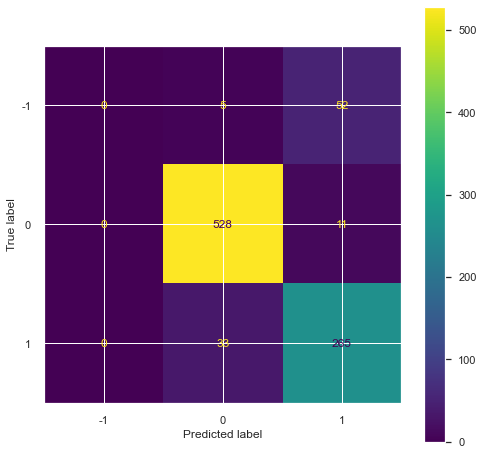

In [102]:
2# tfidf vectorizer
tfidf = TfidfVectorizer(stop_words=stopwords_list, max_features=500, ngram_range=(1,3), min_df=5, tokenizer=lemmatize)

# One hot encoder
ohe = OneHotEncoder(handle_unknown='ignore')

# pipeline to one hot encode dataframe
ohe_pipe = Pipeline(steps=[
    ('to_df', series_FT),
    ('ohe', ohe),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

# pipeline for vectorizing
vector_pipe = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ('vector', tfidf),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

# pipeline for TfIdf and One Hot Encoder
CT = ColumnTransformer(transformers=[
    ('vector_pipe', vector_pipe, ['clean_tweet']),
    ('ohe_pipe', ohe_pipe, ['Manufacturer'])
], remainder='passthrough')

# logreg pipeline
pipe = Pipeline(steps=[
    ('ct', CT),
    ('estimator', RidgeClassifier(random_state=42))
])

param_grid = {}
param_grid['estimator__alpha'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           verbose=1)

# Fit models run gridsearch
grid_search.fit(X_train, y_train)

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

# Set figsize and font scale
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Neg (-)', 'Neutral', 'Pos (+)']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=best_grid,
                      X=X_test,
                      y_true=y_test)

target_names = ['Neg (-)', 'Neutral', 'Pos (+)']
print(classification_report(y_test, y_pred))

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_Ridge');

Ridge yields a more overfit model, but it performs slightly better

#### K-Nearest Neighbors (KNN)

In [ ]:
pipe = Pipeline(steps=[
    ('estimator', KNeighborsClassifier())])

param_grid = {}
param_grid['estimator__n_neighbors'] = [1, 5, 9, 13, 17, 21]
param_grid['estimator__metric'] = ['euclidean', 'manhattan', 'minkowski']
param_grid['estimator__weights'] = ['uniform', 'distance']
    
grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           verbose=2)

# Fit models run gridsearch
grid_search.fit(X_train, y_train)

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

# Set figsize and font scale
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Pos(+)', 'Neutral', 'Neg(-)']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=best_grid,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)

target_names = ['Pos(+)', 'Neutral', 'Neg(-)']
print(classification_report(y_test, y_pred, target_names=target_names))

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_KNN');

KNN not good

#### Multinomial Naive Bayes

Fitting 30 folds for each of 5 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.9min finished


Mean Training Score: 89.23%

Mean Test Score: 88.70%

Optimal Parameters: {'estimator__alpha': 0.01}

Testing Accuracy: 89.23%

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        57
           0       0.93      0.98      0.96       539
           1       0.81      0.89      0.85       298

    accuracy                           0.89       894
   macro avg       0.58      0.62      0.60       894
weighted avg       0.83      0.89      0.86       894



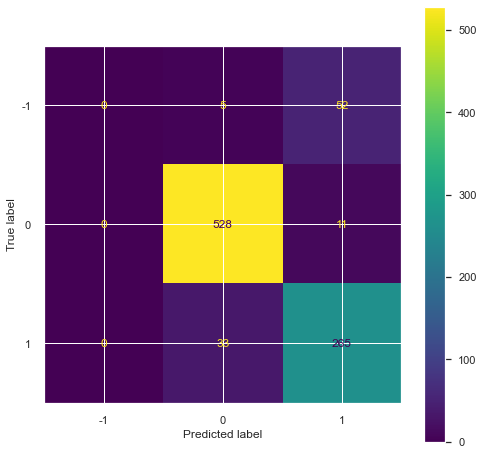

In [103]:
# tfidf vectorizer
tfidf = TfidfVectorizer(stop_words=stopwords_list, max_features=500, ngram_range=(1,3), min_df=2, tokenizer=lemmatize)

# One hot encoder
ohe = OneHotEncoder(handle_unknown='ignore')

# pipeline to one hot encode dataframe
ohe_pipe = Pipeline(steps=[
    ('to_df', series_FT),
    ('ohe', ohe),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

# pipeline for vectorizing
vector_pipe = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ('vector', tfidf),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

# pipeline for TfIdf and One Hot Encoder
CT = ColumnTransformer(transformers=[
    ('vector_pipe', vector_pipe, ['clean_tweet']),
    ('ohe_pipe', ohe_pipe, ['Manufacturer'])
], remainder='passthrough')

# logreg pipeline
pipe = Pipeline(steps=[
    ('ct', CT),
    ('estimator', MultinomialNB())
])

param_grid = {}
param_grid['estimator__alpha'] = [0.01, 0.1, 0.5, 1.0, 10.0]

grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           verbose=1)

# Fit models run gridsearch
grid_search.fit(X_train, y_train)

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

# Set figsize and font scale
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Neg (-)', 'Neutral', 'Pos (+)']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=best_grid,
                      X=X_test,
                      y_true=y_test)

target_names = ['Neg (-)', 'Neutral', 'Pos (+)']
print(classification_report(y_test, y_pred))

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_MultinomialNB');

#### Support Vector Machine

In [ ]:
# tfidf vectorizer
tfidf = TfidfVectorizer(stop_words=stopwords_list, max_features=500, ngram_range=(1,3), min_df=2, tokenizer=lemmatize)

# One hot encoder
ohe = OneHotEncoder(handle_unknown='ignore')

# pipeline to one hot encode dataframe
ohe_pipe = Pipeline(steps=[
    ('to_df', series_FT),
    ('ohe', ohe),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

# pipeline for vectorizing
vector_pipe = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ('vector', tfidf),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

# pipeline for TfIdf and One Hot Encoder
CT = ColumnTransformer(transformers=[
    ('vector_pipe', vector_pipe, ['clean_tweet']),
    ('ohe_pipe', ohe_pipe, ['Manufacturer'])
], remainder='passthrough')

# logreg pipeline
pipe = Pipeline(steps=[
    ('ct', CT),
    ('estimator', SVC())
])

param_grid = {}
param_grid['estimator__kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid['estimator__C'] = [10, 1.0, 0.1]


grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           verbose=1)

# Fit models run gridsearch
grid_search.fit(X_train, y_train)

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

# Set figsize and font scale
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Neg (-)', 'Neutral', 'Pos (+)']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=best_grid,
                      X=X_test,
                      y_true=y_test)

target_names = ['Neg (-)', 'Neutral', 'Pos (+)']
print(classification_report(y_test, y_pred))

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_SVM');

#### Random Forest

In [ ]:
pipe = Pipeline(steps=[
    ('estimator', RandomForestClassifier(random_state=42))
])

param_grid = {}
param_grid['estimator__n_estimators'] = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
param_grid['estimator__max_features'] = ['auto', 'sqrt', 'log2']
param_grid['estimator__max_depth'] = [int(x) for x in np.linspace(10, 110, num=11)]
param_grid['estimator__min_samples_split'] = [2, 5, 10]
param_grid['estimator__min_samples_leaf'] = [1, 2, 4]

grid_search = RandomizedSearchCV(estimator=pipe, 
                                 param_distributions=param_grid, 
                                 cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                                 return_train_score=True, 
                                 scoring='accuracy', 
                                 n_iter=100, 
                                 random_state=42, 
                                 n_jobs=-1, 
                                 verbose=2)

# Fit models run gridsearch
grid_search.fit(X_train, y_train)

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

# Set figsize and font scale
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Pos(+)', 'Neutral', 'Neg(-)']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=best_grid,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)

target_names = ['Pos(+)', 'Neutral', 'Neg(-)']
print(classification_report(y_test, y_pred, target_names=target_names))

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_RandomForest');

# Neural Network Models

In [ ]:
label_encoder = preprocessing.LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Sentiment'])
df.head()

In [ ]:
# one hot encode y_train for neural network modeling
y_train = pd.get_dummies(df['label']).values

In [ ]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(df['Text']))
list_tokenized_headlines = tokenizer.texts_to_sequences(df['Text'])
X_train = sequence.pad_sequences(list_tokenized_headlines)

#### LSTM

In [ ]:
model = Sequential()
embedding_size = 128
model.add(Embedding(20000, 
                    embedding_size))
model.add(LSTM(25, 
               return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, 
                activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, 
                activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])
checkpoint = ModelCheckpoint("best_model_lstm.hdf5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto', 
                             period=1,
                             save_weights_only=False)

print(model.summary())
history = model.fit(X_train,
                     y_train, 
                     epochs=10, 
                     validation_split=.1, 
                     callbacks=[checkpoint])

#### LSTM Bidirectional 

In [ ]:
model = Sequential()
embedding_size = 128
model.add(Embedding(20000, 
                    embedding_size))
model.add(layers.Bidirectional(layers.LSTM(20, 
                                           dropout=0.6)))
model.add(layers.Dense(3, 
                       activation='softmax'))
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
checkpoint = ModelCheckpoint("best_model_bidir.hdf5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto', 
                             period=1,
                             save_weights_only=False)
print(model.summary())
history = model.fit(X_train,
                     y_train, 
                     epochs=10, 
                     validation_split=.1, 
                     callbacks=[checkpoint])

#### RNN

In [ ]:
model = Sequential()
embedding_size = 128
model.add(Embedding(20000, embedding_size))
model.add(layers.SimpleRNN(15, return_sequences=True))
model.add(layers.SimpleRNN(15))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])
checkpoint = ModelCheckpoint("best_model_rnn.hdf5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto', 
                             period=1,
                             save_weights_only=False)
print(model.summary())
history = model.fit(X_train,
                     y_train, 
                     epochs=10, 
                     validation_split=.1, 
                     callbacks=[checkpoint])

#### CNN

In [ ]:
model = Sequential()
embedding_size = 128
model.add(Embedding(20000, embedding_size))
model.add(layers.Conv1D(20, 
                        6, 
                        activation='relu',
                        kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),
                        bias_regularizer=regularizers.l2(2e-3)))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(20, 
                        6, 
                        activation='relu',
                        kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),
                        bias_regularizer=regularizers.l2(2e-3)))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(3,
                       activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])
checkpoint = ModelCheckpoint("best_model_cnn.hdf5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto', 
                             period=1,
                             save_weights_only=False)
print(model.summary())
history = model.fit(X_train,
                     y_train, 
                     epochs=10, 
                     validation_split=.1, 
                     callbacks=[checkpoint])

In [ ]:
model = Sequential()
embedding_size = 128
model.add(Embedding(20000, 
                    embedding_size))
model.add(layers.Bidirectional(layers.LSTM(20, 
                                           dropout=0.6)))
model.add(layers.Dense(3, 
                       activation='softmax'))
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
checkpoint = ModelCheckpoint("best_model_bidir.hdf5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto', 
                             period=1,
                             save_weights_only=False)
print(model.summary())
history = model.fit(X_train,
                     y_train, 
                     epochs=10, 
                     validation_split=.1, 
                     callbacks=[checkpoint])

#### Simple NN

In [ ]:
# ⏰ This cell may take about thirty seconds to run

# Raw text complaints
tweets = df['Text'] 

# Initialize a tokenizer 
tokenizer = Tokenizer(num_words=2000) 

# Fit it to the complaints
tokenizer.fit_on_texts(tweets) 

# Generate sequences
sequences = tokenizer.texts_to_sequences(tweets) 
print('sequences type:', type(sequences))

# Similar to sequences, but returns a numpy array
one_hot_results= tokenizer.texts_to_matrix(tweets, mode='binary') 
print('one_hot_results type:', type(one_hot_results))

# Useful if we wish to decode (more explanation below)
word_index = tokenizer.word_index 

# Tokens are the number of unique words across the corpus
print('Found %s unique tokens.' % len(word_index)) 

# Our coded data
print('Dimensions of our coded results:', np.shape(one_hot_results)) 

In [ ]:
# Your code here
reverse_index = dict([(value, key) for (key, value) in word_index.items()])

In [ ]:
comment_idx_to_preview = 19
print('Original complaint text:')
print(tweets[comment_idx_to_preview])
print('\n\n')

# The reverse_index cell block above must be complete in order for this cell block to successively execute 
decoded_review = ' '.join([reverse_index.get(i) for i in sequences[comment_idx_to_preview]])
print('Decoded review from Tokenizer:')
print(decoded_review)

In [ ]:
sentiment = df['Sentiment']

# Initialize
le = preprocessing.LabelEncoder() 
le.fit(sentiment)
print('Original class labels:')
print(list(le.classes_))
print('\n')
product_cat = le.transform(sentiment)  

# If you wish to retrieve the original descriptive labels post production
# list(le.inverse_transform([0, 1, 3, 3, 0, 6, 4])) 

print('New sentiment labels:')
print(product_cat)
print('\n')

# Each row will be all zeros except for the category for that observation 
print('One hot labels; 3 binary columns, one for each of the categories.') 
product_onehot = to_categorical(product_cat)
print(product_onehot)
print('\n')

print('One hot labels shape:')
print(np.shape(product_onehot))

In [ ]:
random.seed(42)
test_index = random.sample(range(1, 8936), 1500)

test = one_hot_results[test_index]
train = np.delete(one_hot_results, test_index, 0)

label_test = product_onehot[test_index]
label_train = np.delete(product_onehot, test_index, 0)

print('Test label shape:', np.shape(label_test))
print('Train label shape:', np.shape(label_train))
print('Test shape:', np.shape(test))
print('Train shape:', np.shape(train))

In [ ]:
# Initialize a sequential model
model = models.Sequential()

# Two layers with relu activation
model.add(layers.Dense(50, activation='relu', input_shape=(2000,)))
model.add(layers.Dense(25, activation='relu'))

# One layer with softmax activation 
model.add(layers.Dense(3, activation='softmax'))

In [ ]:
# Compile the model
model.compile(optimizer='SGD',
         # Train the model 
history = model.fit(train,
                    label_train,
                    epochs=100,
                    batch_size=256)     loss='categorical_crossentropy',
              metrics=['acc'])

In [ ]:
# Train the model 
history = model.fit(train,
                    label_train,
                    epochs=100,
                    batch_size=256)

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
# Plot the loss vs the number of epoch
history_dict = history.history
loss_values = history_dict['loss']

epochs = range(1, len(loss_values) + 1)

visual = sns.lineplot(x=epochs, 
                      y=loss_values, 
                      label='Training Loss', 
                      color='#00A36C')
visual.set_title('Training Loss')
visual.set_xlabel('Epochs')
visual.set_ylabel('Loss');

In [ ]:
# Plot the training accuracy vs the number of epochs
accuracy_values = history_dict['acc']

epochs = range(1, len(loss_values) + 1)

visual = sns.lineplot(x=epochs, 
                      y=loss_values, 
                      label='Training Accuracy', 
                      color='#FF3131')
visual.set_title('Training Accuracy')
visual.set_xlabel('Epochs')
visual.set_ylabel('Loss');

In [ ]:
# Output (probability) predictions for the test set 
y_hat_test = model.predict(test)

In [ ]:
# Print the loss and accuracy for the training set 
results_train = model.evaluate(train, label_train)
results_train

In [ ]:
# Print the loss and accuracy for the test set 
results_test = model.evaluate(test, label_test)
results_test

# Model Comparison

In [ ]:
# Script to test the effectivenes of each model, uses best parameters from grid and randomized searches done above
# Test 6 different classification models 
def run_exps(X_train, y_train, X_test, y_test) :
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    
    models = [
          ('Log Reg', LogisticRegression(random_state=42,
                                        C=10,
                                        penalty='l2',
                                        solver='liblinear',
                                        n_jobs=-1)), 
          
          ('Ridge', RidgeClassifier(alpha=.6)),
         
          ('Random Forest', RandomForestClassifier(random_state=42,
                                        n_jobs=-1)),
          
          ('KNN', KNeighborsClassifier(n_jobs=-1)),
           
          ('Multinomial NB', MultinomialNB(alpha=0.5)),
        
        
          ('SVM', SVC(random_state=42,
                      C=1.0,
                      kernel='linear'))
        ]
   
    results = []
    
    names = []
    
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    
    target_names = ['Pos (+)', 'Neutral', 'Neg (-)']
    
    for name, model in models:
        
        kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
        cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        
        results.append(cv_results)
        names.append(name)
        
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        
    final = pd.concat(dfs, ignore_index=True)
    
    return final
final = run_exps(X_train, y_train, X_test, y_test)
final

In [ ]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, 
                         ignore_index=True)
results_long = pd.melt(bootstrap_df, 
                       id_vars=['model'], 
                       var_name='metrics', 
                       value_name='values')
time_metrics = ['fit_time', 'score_time'] # fit time metrics

## Performance metrics
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')

## Time metrics
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

In [ ]:
plt.figure(figsize=(20, 12))
g = sns.boxplot(x="model", 
                y="values", 
                hue="metrics", 
                data=results_long_nofit, 
                palette="crest")
g.set_xticklabels(g.get_xticklabels(), rotation=30)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./images/benchmark_models_performance.png',dpi=300)

# Final Model

In [ ]:
pipe = Pipeline(steps=[
    ('estimator', LogisticRegression(random_state=42))
])

param_grid = {}
param_grid['estimator__C'] = [100, 10, 1.0, 0.1, 0.01]
param_grid['estimator__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
param_grid['estimator__penalty'] = ['l2']

grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           verbose=2)

# Fit models run gridsearch
grid_search.fit(X_train, y_train)

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

# Set figsize and font scale
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Pos (+)', 'Neutral', 'Neg (-)']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=best_grid,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)

target_names = ['Pos (+)', 'Neutral', 'Neg (-)']
print(classification_report(y_test, y_pred, target_names=target_names))

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_LogReg');